In [1]:
#this line is necessary to make the plots show up inline and editable
%matplotlib notebook

#let's import some packages we'll use
import pandas
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

In [2]:
#find nice colours at https://www.color-hex.com/
colours = ['#9fa3a3','#4b5565','#6f0c4f','#47c0ba','#c7592a','#6f0c4f','#af74b0'] 

#what we'll call our two samples on plots (and also the file names, for convenient handing!)
sample_names  = ['signal','background']

luminosity = 140.*1000 #in pb = 300 fb^-1

#these come from the rivet logfiles!
#if you're using madgraph events the sum of weights should always be ~ the cross-section
#because madgraph sets each event weight = cross_section / nEvents 
#so this is pretty redundant. But it's not always true!

sum_of_weights = [0.651708,27.2705] #this is basically the XS, within error...
cross_sections = [0.651708,27.2705] 

#find the scale factor for all the samples to correct nEvents -> number expected inside a dataset of size = luminosity
#here, luminosity = 140/fb because that is the size of the already collected run 2 dataset

scale_factors = [luminosity * xs / sw for xs,sw in zip(cross_sections,sum_of_weights)]

In [3]:
#example of how to print out some values. Let's sanity-check our scale factors!
print (scale_factors)

[140000.0, 140000.0]


In [4]:
#path to your data!
#here, I am assuming you have changed the name of rivet_example.csv to rivet_example_background.csv
#because it's our background for this toy analysis!

file_path = '/eos/user/h/hrussell/rivet-analysis/'

#load the two files as dataframes:
my_samples = [pandas.read_csv(file_path+"rivet_example_"+sample+".csv") for sample in sample_names]

In [5]:
#we can look at what's inside the dataframe with the .head() function. This is good to make sure that 
#loading the csv files worked properly (check them all, not just entry 0!)
my_samples[0].head()

weight       yz3       lz3    pTlep   pTgamma  ly_costhetastar      lydr  \
0  0.000013  0.780774 -0.780774  68.2544   18.5411         0.825537  1.686760   
1  0.000013  1.863620 -1.863620  45.0381  151.6150         0.859670  4.205370   
2  0.000013  0.738601 -0.738601  50.4039   16.1276         0.791101  3.355860   
3  0.000013  0.314882 -0.314882  35.7127   97.0401         0.171391  0.759897   
4  0.000013 -0.852073  0.852073  62.6477   25.2493        -0.819586  1.875380   

     lydeta    lydphi       mly   ...         yeta      yphi      j1pt  \
0  1.561550  0.637752   65.2968   ...     0.063234  4.788310   75.1485   
1  3.727240  1.947520  537.5950   ...     2.069920  4.737730  166.2170   
2  1.477200  3.013250   73.2053   ...     1.318250  6.133890   96.4931   
3  0.629764  0.425254   45.1421   ...    -0.280968  5.354830  103.4300   
4  1.704150  0.782897   82.0969   ...    -1.183440  0.374719  149.5940   

       j1pz    j1eta     j1phi      j2pt       j2pz     j2eta    j2phi  
0  -316.042 -2.14340  1.374100   68.2544 -145.06200 -1.498310  4.15056  
1  1070.780  2.56197  1.485390  156.7180  610.34800  2.068820  4.74105  
2   853.967  2.87675  0.671316   50.4039   -8.04573 -0.158955  3.12063  
3   251.274  1.62069  1.768060   98.8902  -27.91270 -0.278640  5.35629  
4  -333.133 -1.54074  3.968500   63.7951   35.03090  0.524706  1.15476  

[5 rows x 32 columns]

now, we're going to add another column to the dataframes that tells us whether the sample is signal or background 
you could do something more complicated, but we only have two so 0 and 1 works.
this is so we can send the dataset into fancy machine learning algorithms and it knows which events are 
signal and which are background for the training sample!

In [6]:
my_samples[0]['isSignal'] = [1 for i in range(my_samples[0].shape[0])]
my_samples[1]['isSignal'] = [0 for i in range(my_samples[1].shape[0])]

#then we combine the two datasets into a single, big dataset
my_dataset = my_samples[0].append(my_samples[1],ignore_index=True)

#we can see that this worked by filtering events from the dataset with isSignal == 0 
my_dataset[my_dataset['isSignal']==0].head()

weight       yz3       lz3     pTlep   pTgamma  ly_costhetastar  \
1883  0.000545 -0.103037  0.103037  129.7920   68.7285        -0.133821   
1884  0.000545 -0.603661  0.603661   39.7079   21.8985        -0.641636   
1885  0.000545  0.115421 -0.115421   35.7888  101.9060         0.060115   
1886  0.000545 -1.962520  1.962520   47.5055   25.2118        -0.978721   
1887  0.000545 -0.779368  0.779368   31.2204   50.7366        -0.553046   

         lydr    lydeta    lydphi       mly    ...         yphi      j1pt  \
1883  1.20498  0.206073  1.187220  107.4450    ...     3.481970  177.4540   
1884  2.07589  1.207320  1.688700   58.0756    ...     1.736360   59.2660   
1885  2.75274  0.230842  2.743040  119.2140    ...     0.829181  103.4300   
1886  3.97071  3.925040  0.600519  242.3150    ...     4.023790   97.2040   
1887  3.27539  1.558740  2.880720  104.5110    ...     1.507170   51.2677   

         j1pz     j1eta     j1phi      j2pt       j2pz     j2eta    j2phi  \
1883  481.601  1.723890  6.067740  132.1760    86.3411  0.613931  2.29575   
1884 -114.993 -1.416600  1.942270   51.0132  -690.6240 -3.300020  5.52055   
1885 -333.110 -1.886000  0.827267   51.9624  -241.8690 -2.242360  1.87633   
1886 -105.096 -0.937636  1.179680   57.6947  -201.0300 -1.961420  4.69005   
1887 -101.296 -1.432780  1.506320   48.2007 -3015.9700 -4.829510  3.80003   

      isSignal  
1883         0  
1884         0  
1885         0  
1886         0  
1887         0  

[5 rows x 33 columns]

since all the variables don't necessarily show up well in .head() if you have too many, this is how you list what variables are contained in the dataframe:

In [7]:
print (list(my_dataset))

['weight', 'yz3', 'lz3', 'pTlep', 'pTgamma', 'ly_costhetastar', 'lydr', 'lydeta', 'lydphi', 'mly', 'jjdr', 'jjdeta', 'jjdphi', 'mjj', 'MET', 'MET_phi', 'lpt', 'lpz', 'leta', 'lphi', 'ypt', 'ypz', 'yeta', 'yphi', 'j1pt', 'j1pz', 'j1eta', 'j1phi', 'j2pt', 'j2pz', 'j2eta', 'j2phi', 'isSignal']


I'm getting bored with typing my_samples[0] and my_samples[1], and since there are only two samples 
we're working with I'm just going to rename them sig (signal) and bkg (background).

In [8]:
sig = my_samples[0]
bkg = my_samples[1]

In [9]:
#for some reason you need to do this again:
#maybe after you've drawn your first plot? and then plot again? 
#it will change the plot so it is editable
#you'll know when it works!
%matplotlib notebook

Now we're going to make some plots, using matplotlib. Try playing around with the different options so you know what each of them does!

<IPython.core.display.Javascript object>


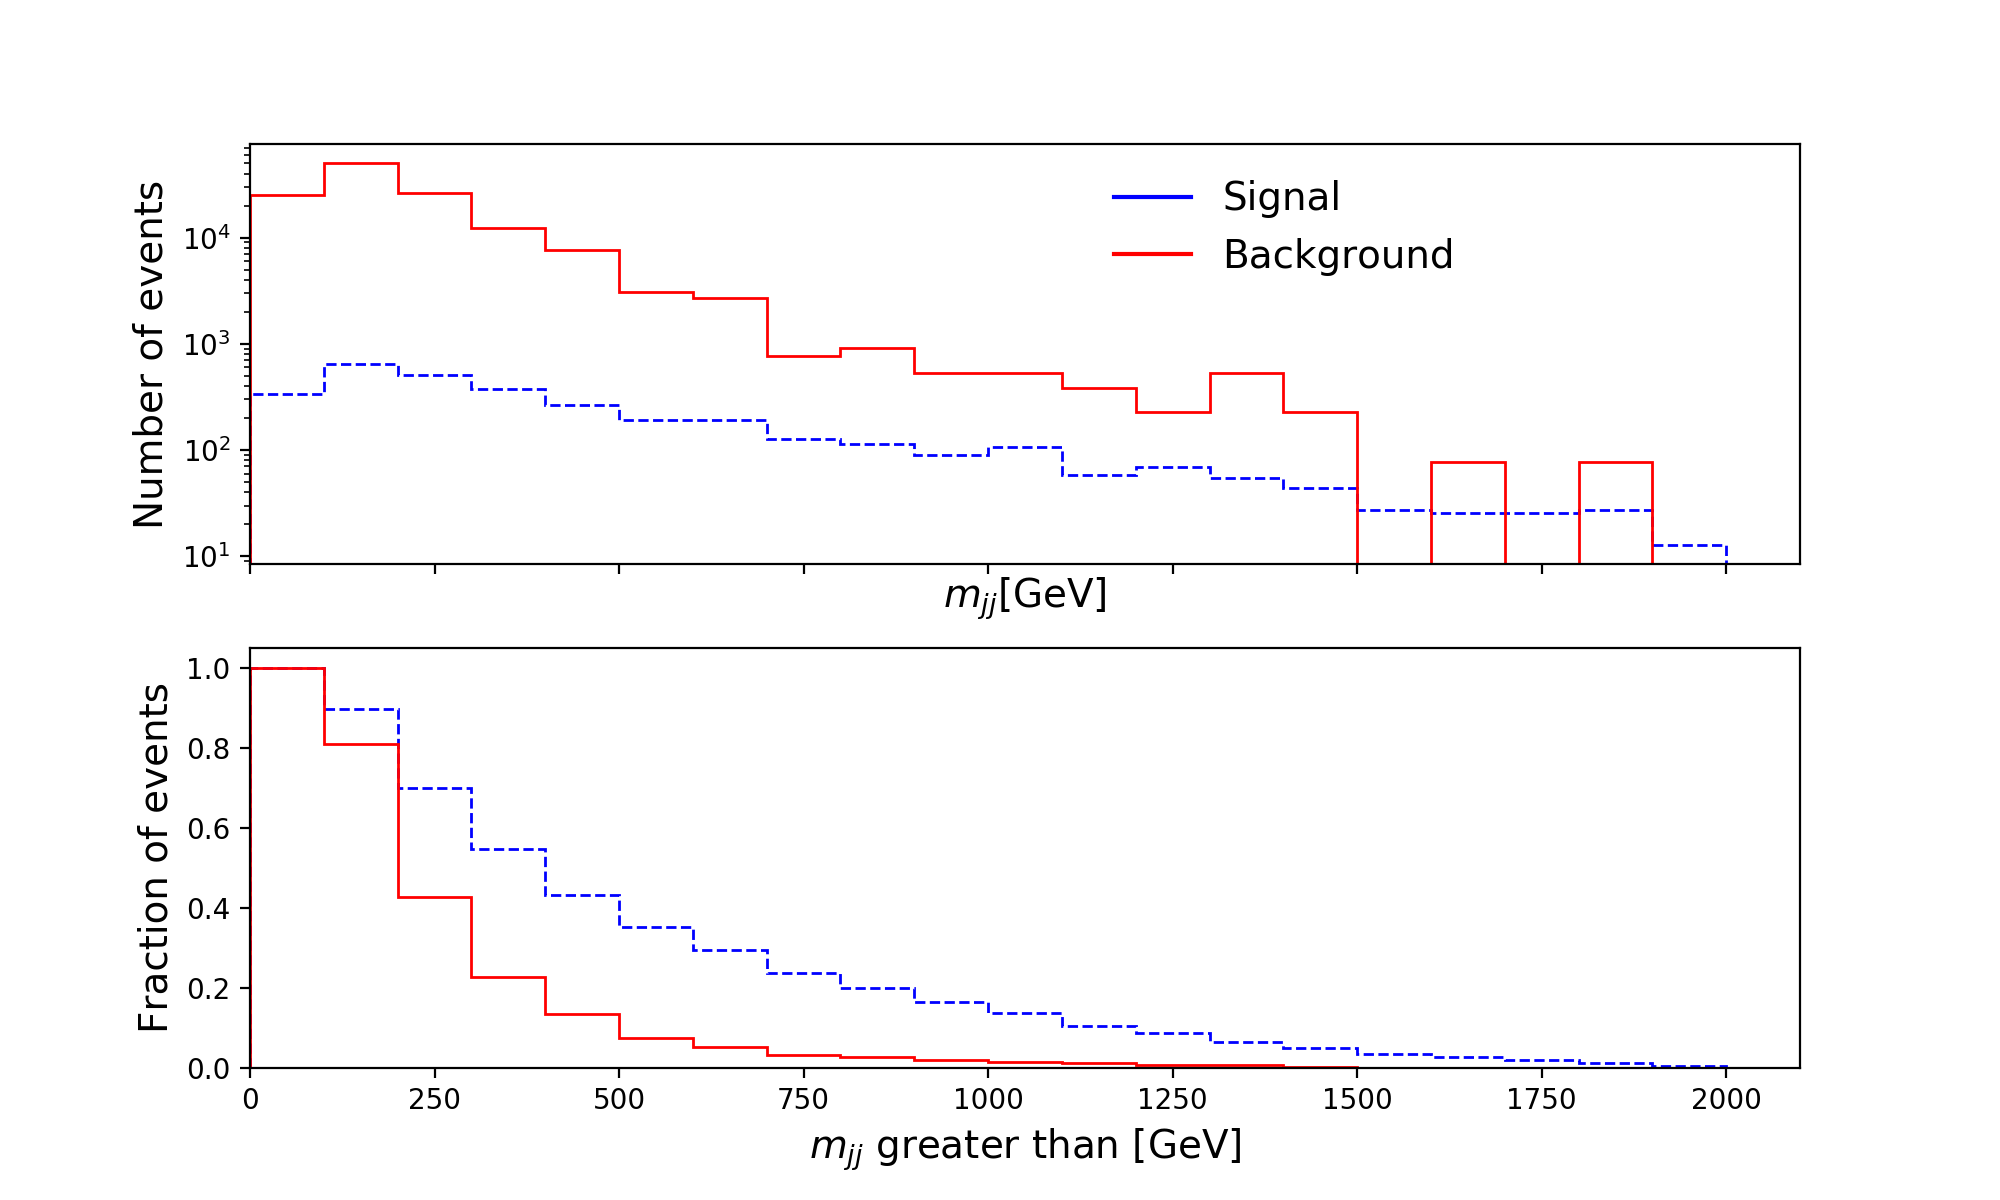

/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [10]:
#you always need to close existing plots before plotting, or they'll show up on the old canvas! 
plt.close('all')

#let's first plot a 1d histogram of the invariant mass between two jets:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True)

ax1.hist(sig['mjj'], weights = sig['weight']*scale_factors[0],bins=20,range=(0,2000),color='blue',
             fill=False,histtype='step',label='Signal',linestyle='--')
    
ax1.hist(bkg['mjj'], weights = bkg['weight']*scale_factors[1],bins=20,range=(0,2000),color='red',
              fill=False,histtype='step',label='Background')

ax1.set_yscale('log')
ax1.set_xlim(left=0)
ax1.set_ylabel('Number of events', fontsize=14)
ax1.set_xlabel(r'$m_{jj}$'+'[GeV]',fontsize=14)

#don't forget the legend!
#First, we need to create new legend handles but use the colors from the existing ones
#otherwise the legend shows up as a "box" instead of a line (try it out!)

handles, labels = ax1.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], c=h.get_edgecolor()) for h in handles]

lgnd = ax1.legend(handles = new_handles, labels = labels, loc='right', 
                  bbox_to_anchor=(0.8, 0.8),prop={'size':14},framealpha=0)

#Now, it's not super obvious to see the difference between the two shapes when they're normalized to cross-section
#Let's create an integrated plot showing the fraction of events we'd get by applying a cut at mjj = X GeV

ax2.hist(sig['mjj'], weights = sig['weight']*scale_factors[0],bins=20,range=(0,2000),color='blue',
             fill=False,histtype='step', cumulative=-1,normed=True,linestyle='--')
    
ax2.hist(bkg['mjj'], weights = bkg['weight']*scale_factors[1],bins=20,range=(0,2000),color='red',
              fill=False,histtype='step',cumulative=-1,normed=True)

ax2.set_ylabel('Fraction of events', fontsize=14)
ax2.set_xlabel(r'$m_{jj}$'+' greater than [GeV]',fontsize=14)

plt.show()

The first plot we drew is the raw distribution of the number of events per mjj bin. The second plot is the fraction of events at and above a given mjj. Notice that the first bin has value 1.0 - because all events are above mjj = 0.

There is one issue with plotting an integrated histogram when the uppermost bin value is hard-coded: what happens to data above the cut? As a test, we can find the maximum mjj value from the singal array, and notice that it's much higher than the max value of 2000 GeV we set in the above histograms:

In [11]:
max(sig['mjj'])

6133.85

We could instead put all overflow into a single bin at the end, using np.clip (carefully look at the difference in the tail of the signal histogram, and how affected our conclusions might have been if we'd only looked the previous plot!):

<IPython.core.display.Javascript object>


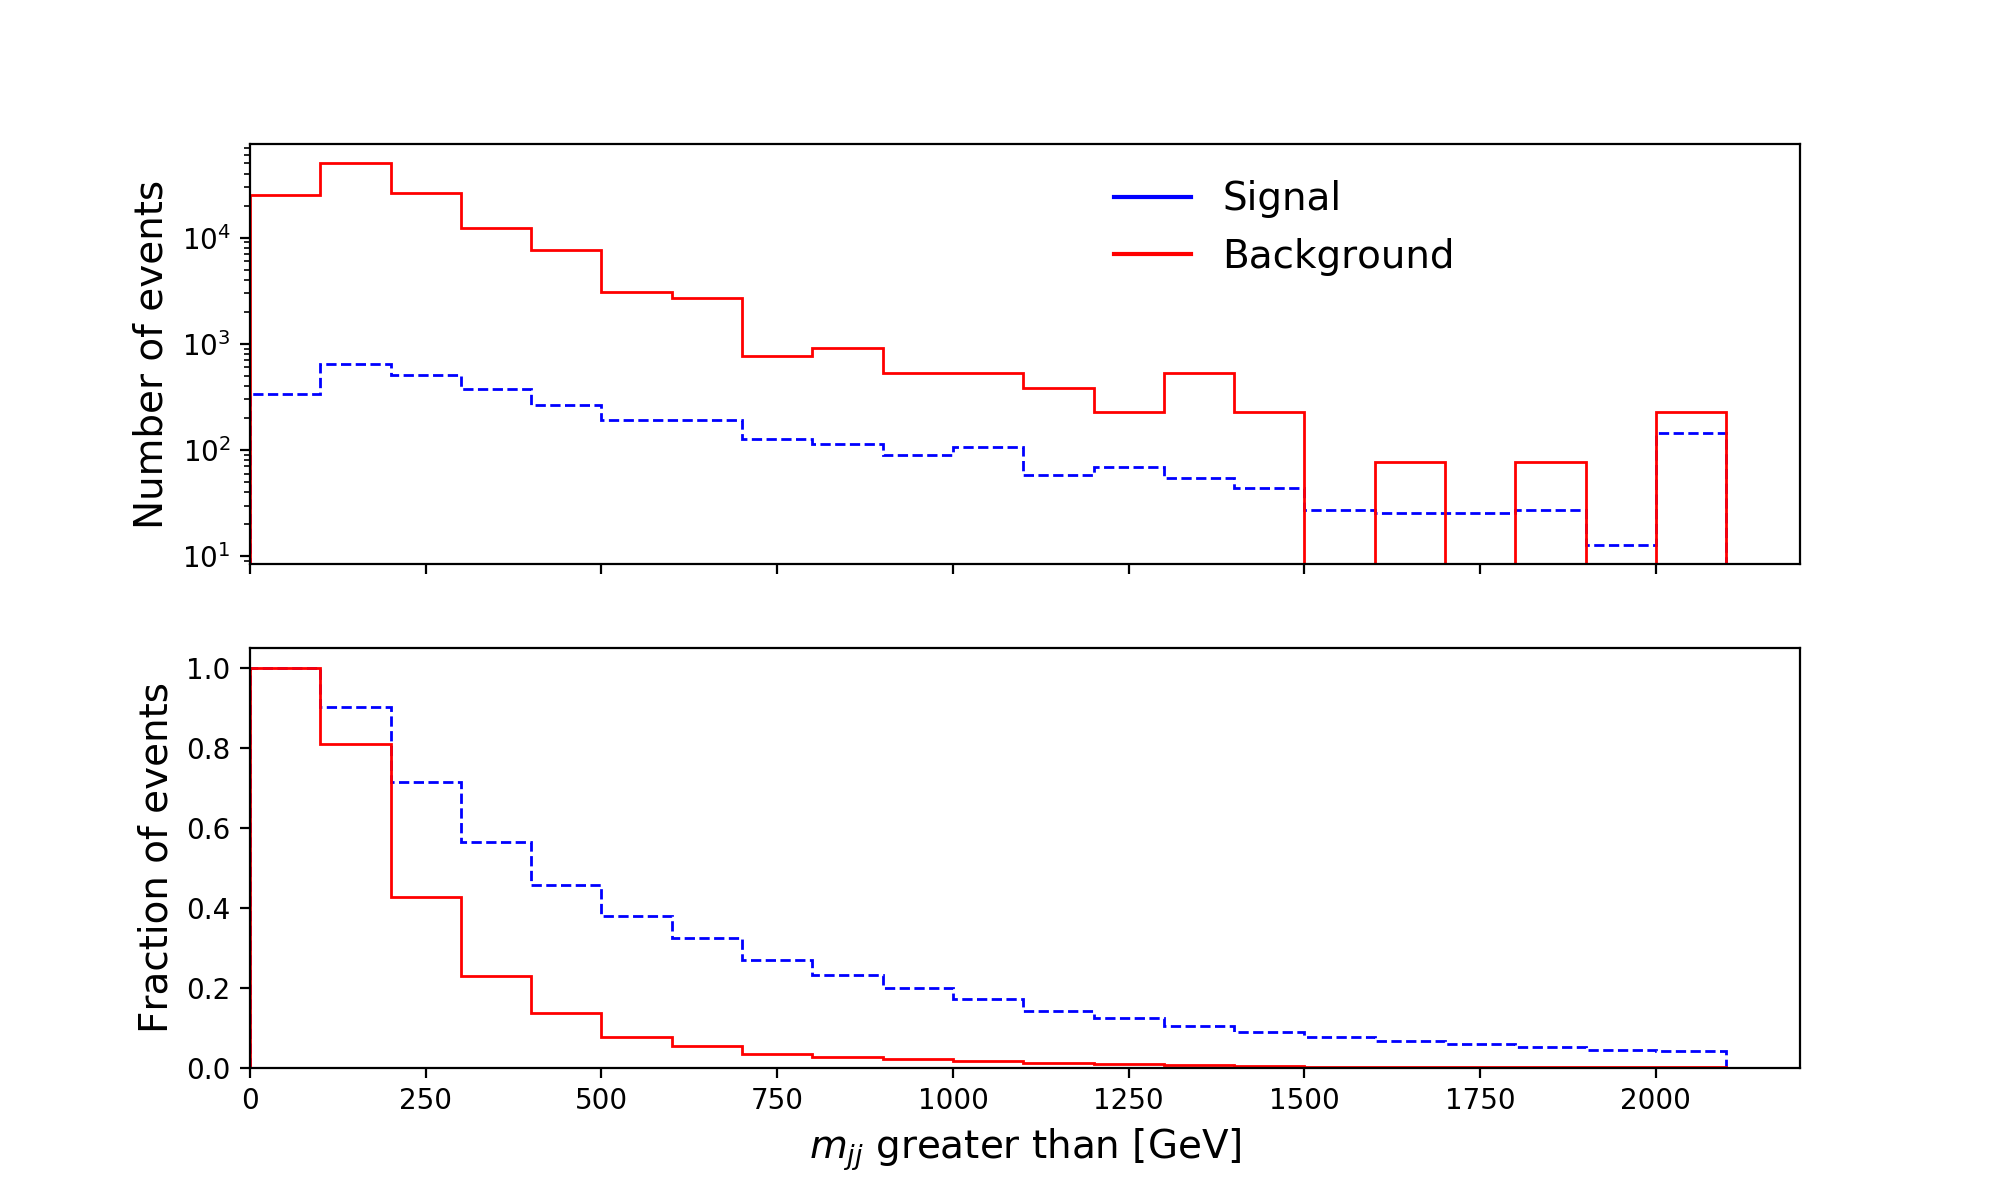

In [12]:
#you always need to close existing plots before plotting, or they'll show up on the old canvas!
plt.close('all')

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True,squeeze=True)

#this time, we need to pre-define the bins (you could have done this before, too, to save manually setting the
#same binning for each histogram!)

#small catch: arange generates bins in the open interval [start, end) so we need to go two bins above to get
#the overflow > 2000 into one bin (if it's confusing, just make a new cell in the notebook and test some ranges out!)
bins = np.arange(0,2200,100)

ax1.hist(np.clip(sig['mjj'], bins[0], bins[-1]), weights = sig['weight']*scale_factors[0],bins=bins,color='blue',
             fill=False,histtype='step',label='Signal',linestyle='--')
    
ax1.hist(np.clip(bkg['mjj'],bins[0],bins[-1]), weights = bkg['weight']*scale_factors[1],bins=bins,color='red',
              fill=False,histtype='step',label='Background')

ax1.set_yscale('log')
ax1.set_xlim(left=0)
ax1.set_ylabel('Number of events', fontsize=14)

#don't forget the legend!
# First, we need to create new legend handles but use the colors from the existing ones
#otherwise the legend shows up as a "box" instead of a line (try it out!)

handles, labels = ax1.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], c=h.get_edgecolor()) for h in handles]

lgnd = ax1.legend(handles = new_handles, labels = labels, loc='right', 
                  bbox_to_anchor=(0.8, 0.8),prop={'size':14},framealpha=0)

#Now, it's not super obvious to see the difference between the two shapes when they're normalized to cross-section
#Let's create an integrated plot showing the fraction of events we'd get by applying a cut at mjj = X GeV

ax2.hist(np.clip(sig['mjj'], bins[0], bins[-1]), weights = sig['weight']*scale_factors[0],bins=bins,color='blue',
             fill=False, histtype='step', cumulative=-1,normed=True,linestyle='--')
    
ax2.hist(np.clip(bkg['mjj'], bins[0], bins[-1]), weights = bkg['weight']*scale_factors[1],bins=bins,color='red',
              fill=False, histtype='step',cumulative=-1,normed=True)

ax2.set_ylabel('Fraction of events', fontsize=14)
ax2.set_xlabel(r'$m_{jj}$'+' greater than [GeV]',fontsize=14)

plt.show()

So we've found a variable that discriminates well between signal and background - and it looks like a cut of mjj > 500 GeV picks up ~38% of our signal but only 8% of the background. Let's see what the photon and lepton pT distributions look like before and after we make this cut!

<IPython.core.display.Javascript object>


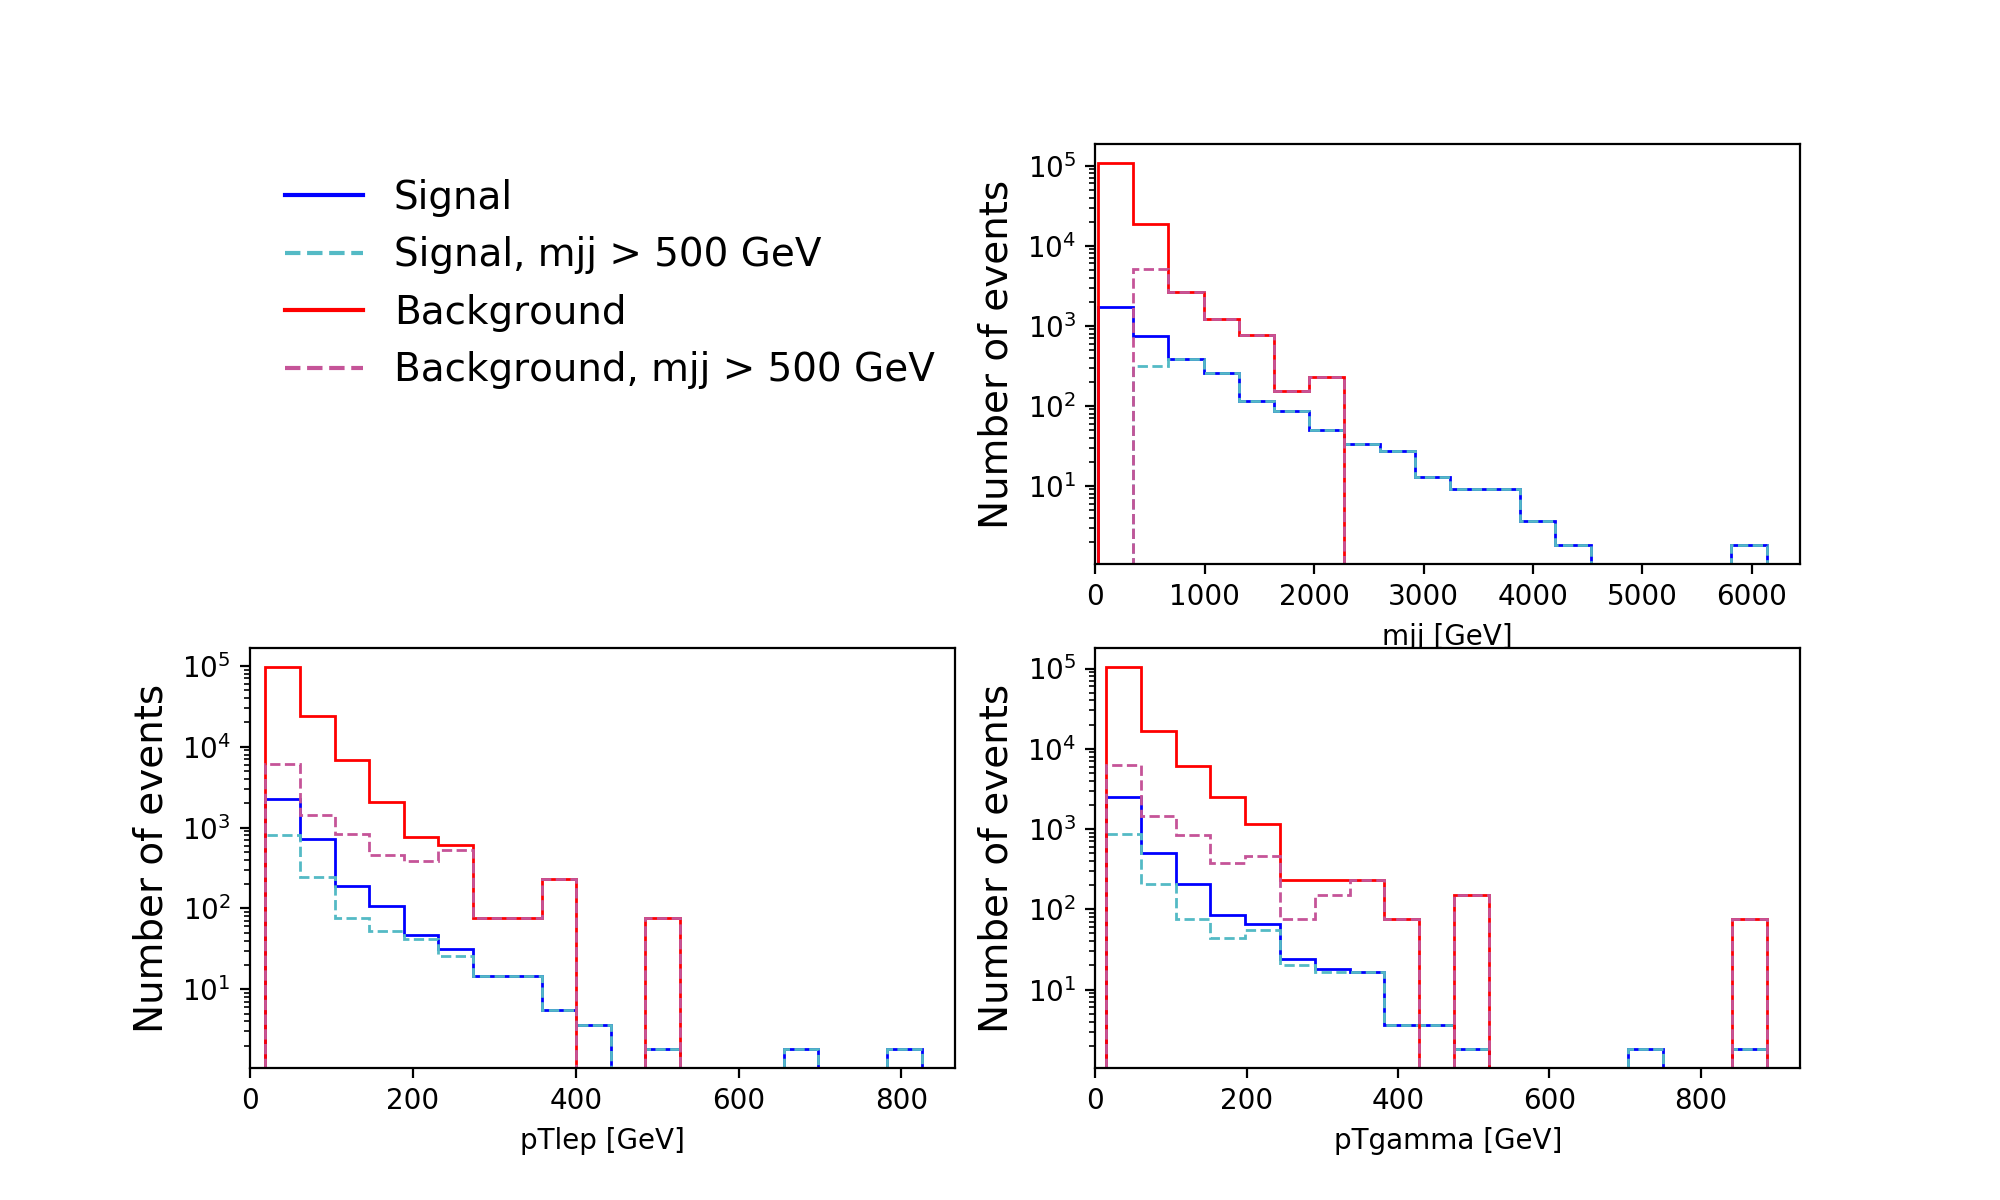

In [13]:
#you always need to close existing plots before plotting, or they'll show up on the old canvas!
plt.close('all')

fig,axes = plt.subplots(2,2,figsize=(10,6),sharex=False,squeeze=True)

#filter the signal and background to only contain events passing our mjj cut
filtered_sig = sig[sig['mjj'] > 500]
filtered_bkg = bkg[bkg['mjj'] > 500]

#we'll do the mjj to show the cut was successful, and then lepton pT, photon pT, and 
#then because the grid is 4x4 we'll put the legend in first grid space
my_variables = ['mjj','pTlep','pTgamma']


#put the legend in the first subplot
legPlot = axes[0][0]
    
legPlot.set_frame_on(False)
legPlot.get_xaxis().set_visible(False)
legPlot.get_yaxis().set_visible(False)

#this is another sort of hacky way of plotting lines - create an empty plot object with the correct style
#and make the legend from that instead!
legPlot.plot(0, 0, linestyle='-', color='blue', label = 'Signal')
legPlot.plot(0, 0, linestyle='--', color='#54bac5', label = 'Signal, mjj > 500 GeV')
legPlot.plot(0, 0, linestyle='-', color='red', label = 'Background')
legPlot.plot(0, 0, linestyle='--', color='#c55498', label = 'Background, mjj > 500 GeV')
legPlot.legend(loc = 'upper left',prop={'size':14},framealpha=0)

for ax,var in zip(axes.flatten()[1:],my_variables):
    
    #calculate some default binning dependent on the max and min values of the variable in the signal dataset
    #here I subtract a bit from the min and add to the max just to make sure I'm covering everything
    bins=np.linspace(min(sig[var])-1,max(sig[var])+1,20)
    
    ax.hist(np.clip(sig[var], bins[0], bins[-1]), weights = sig['weight']*scale_factors[0],bins=bins,color='blue',
             fill=False,histtype='step',label='Signal',linestyle='-')

    ax.hist(np.clip(filtered_sig[var], bins[0], bins[-1]), weights = filtered_sig['weight']*scale_factors[0],bins=bins,color='#54bac5',
             fill=False,histtype='step',label='Signal, mjj > 500 GeV',linestyle='--')    

    ax.hist(np.clip(bkg[var], bins[0], bins[-1]), weights = bkg['weight']*scale_factors[0],bins=bins,color='red',
             fill=False,histtype='step',label='Background',linestyle='-')

    ax.hist(np.clip(filtered_bkg[var], bins[0], bins[-1]), weights = filtered_bkg['weight']*scale_factors[0],bins=bins,color='#c55498',
             fill=False,histtype='step',label='Background, mjj > 500 GeV',linestyle='--')  
    
    ax.set_yscale('log')
    ax.set_xlim(left=0)
    ax.set_ylabel('Number of events', fontsize=14)
    ax.set_xlabel(var+' [GeV]')
    
plt.show()

The mjj plots we've just made show a variable that discriminates well between signal and background. There are probably others, so let's create a quick grid of all the variables in our dataframe and do a visual check. We could also do this for the integrated histograms - try changing the code so that it displays the integral (i.e. the fraction of events above some cut value) instead!

<IPython.core.display.Javascript object>


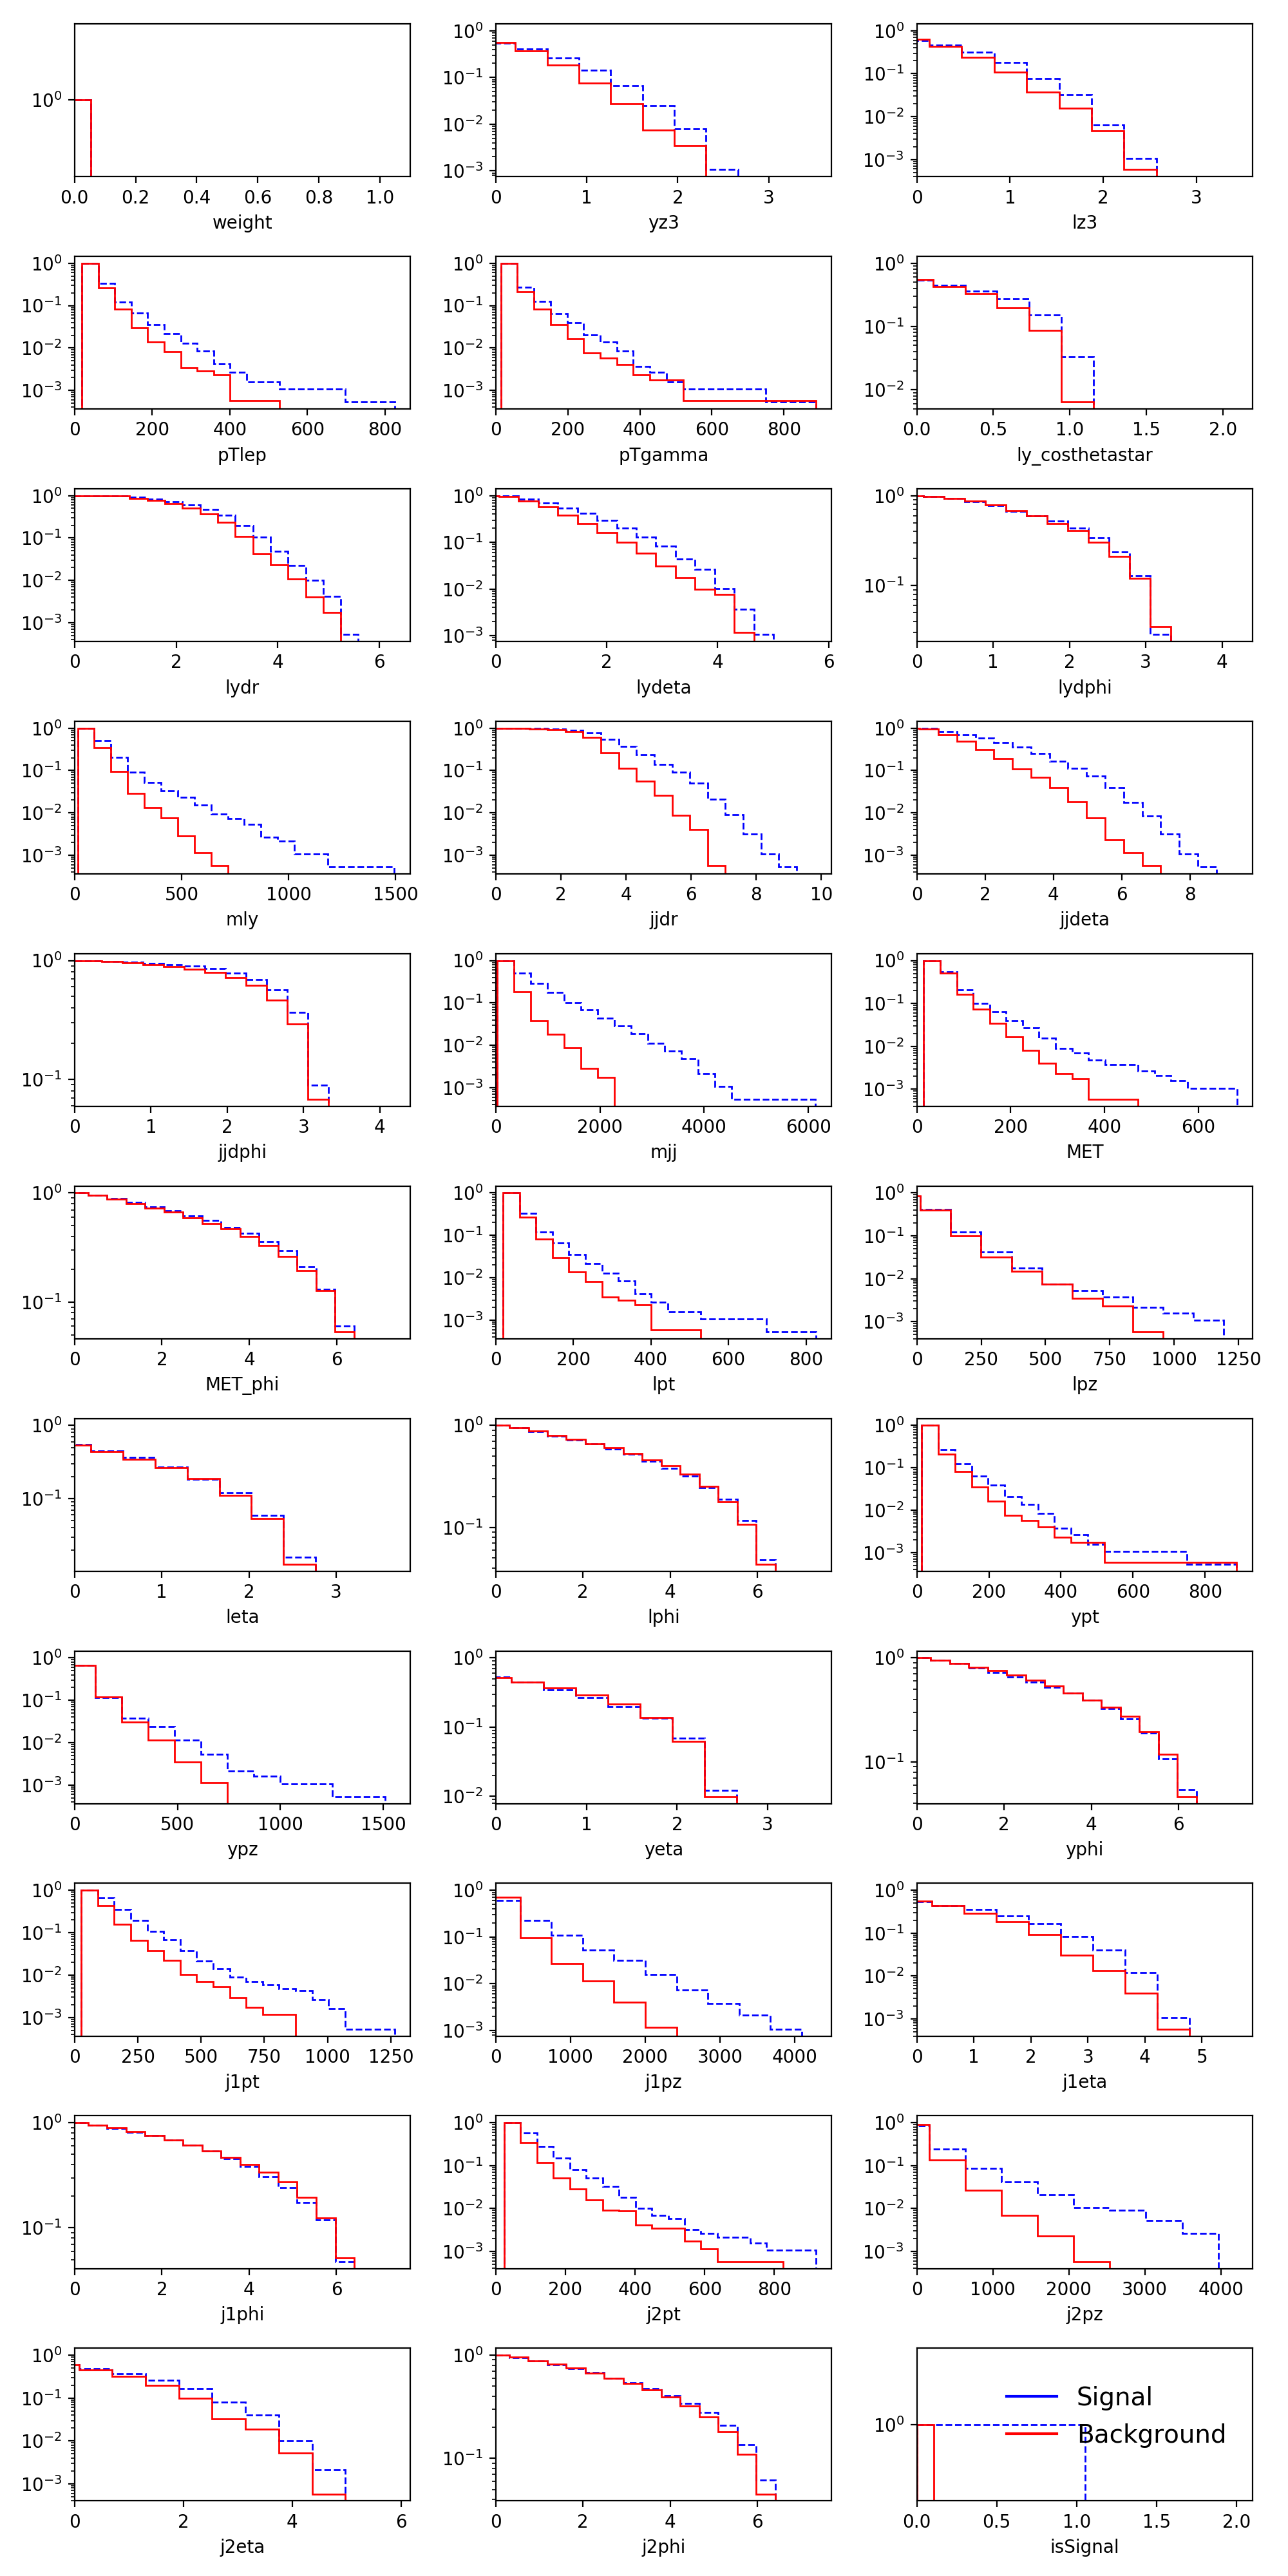

In [14]:
#you always need to close existing plots before plotting, or they'll show up on the old canvas!
plt.close('all')

nvars = len(list(sig))

plt.figure(figsize=(10,20))

for i,var in enumerate(list(sig)):

    #I happen to know I have 33 variables, so 11 x 3 works
    ax = plt.subplot(11,3,i+1)
    #calculate some default binning dependent on the max and min values of the variable in the signal dataset
    #here I subtract a bit from the min and add to the max just to make sure I'm covering everything
    bins=np.linspace(min(sig[var])-1,max(sig[var])+1,20)

    ax.hist(np.clip(sig[var], bins[0], bins[-1]), weights = sig['weight']*scale_factors[0],bins=bins,color='blue',
             fill=False,histtype='step',label='Signal',linestyle='--',cumulative=-1,normed=True)
    
    ax.hist(np.clip(bkg[var],bins[0],bins[-1]), weights = bkg['weight']*scale_factors[1],bins=bins,color='red',
              fill=False,histtype='step',label='Background',cumulative=-1,normed=True)

    ax.set_yscale('log')
    ax.set_xlim(left=0)
    #ax.set_ylabel('Number of events', fontsize=14)
    ax.set_xlabel(var)

#don't forget the legend!
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], c=h.get_edgecolor()) for h in handles]

lgnd = plt.legend(handles = new_handles, labels = labels, loc='upper left', 
                   bbox_to_anchor=(0.2, 0.9),prop={'size':14},framealpha=0)

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.tight_layout()
plt.show()

Let's now pick out a short list of variables that appear to have some discriminating power so we can put them through some machine learning algorithms.

I choose: ly_costhetastar, MET, mjj, jjdeta, and mly.

It's not necessarily the best choice (or a good choice), just an example so we can play around a bit.

You can also try creating some of your own variables as combinations of the above, and then adding them to the dataframe in the same way we added isSignal.

In [15]:
#Import Library
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve

#this is the algorithm we'll use, for no particular reason. See more here:
#https://scikit-learn.org/stable/supervised_learning.html
from sklearn.ensemble import RandomForestClassifier

<IPython.core.display.Javascript object>


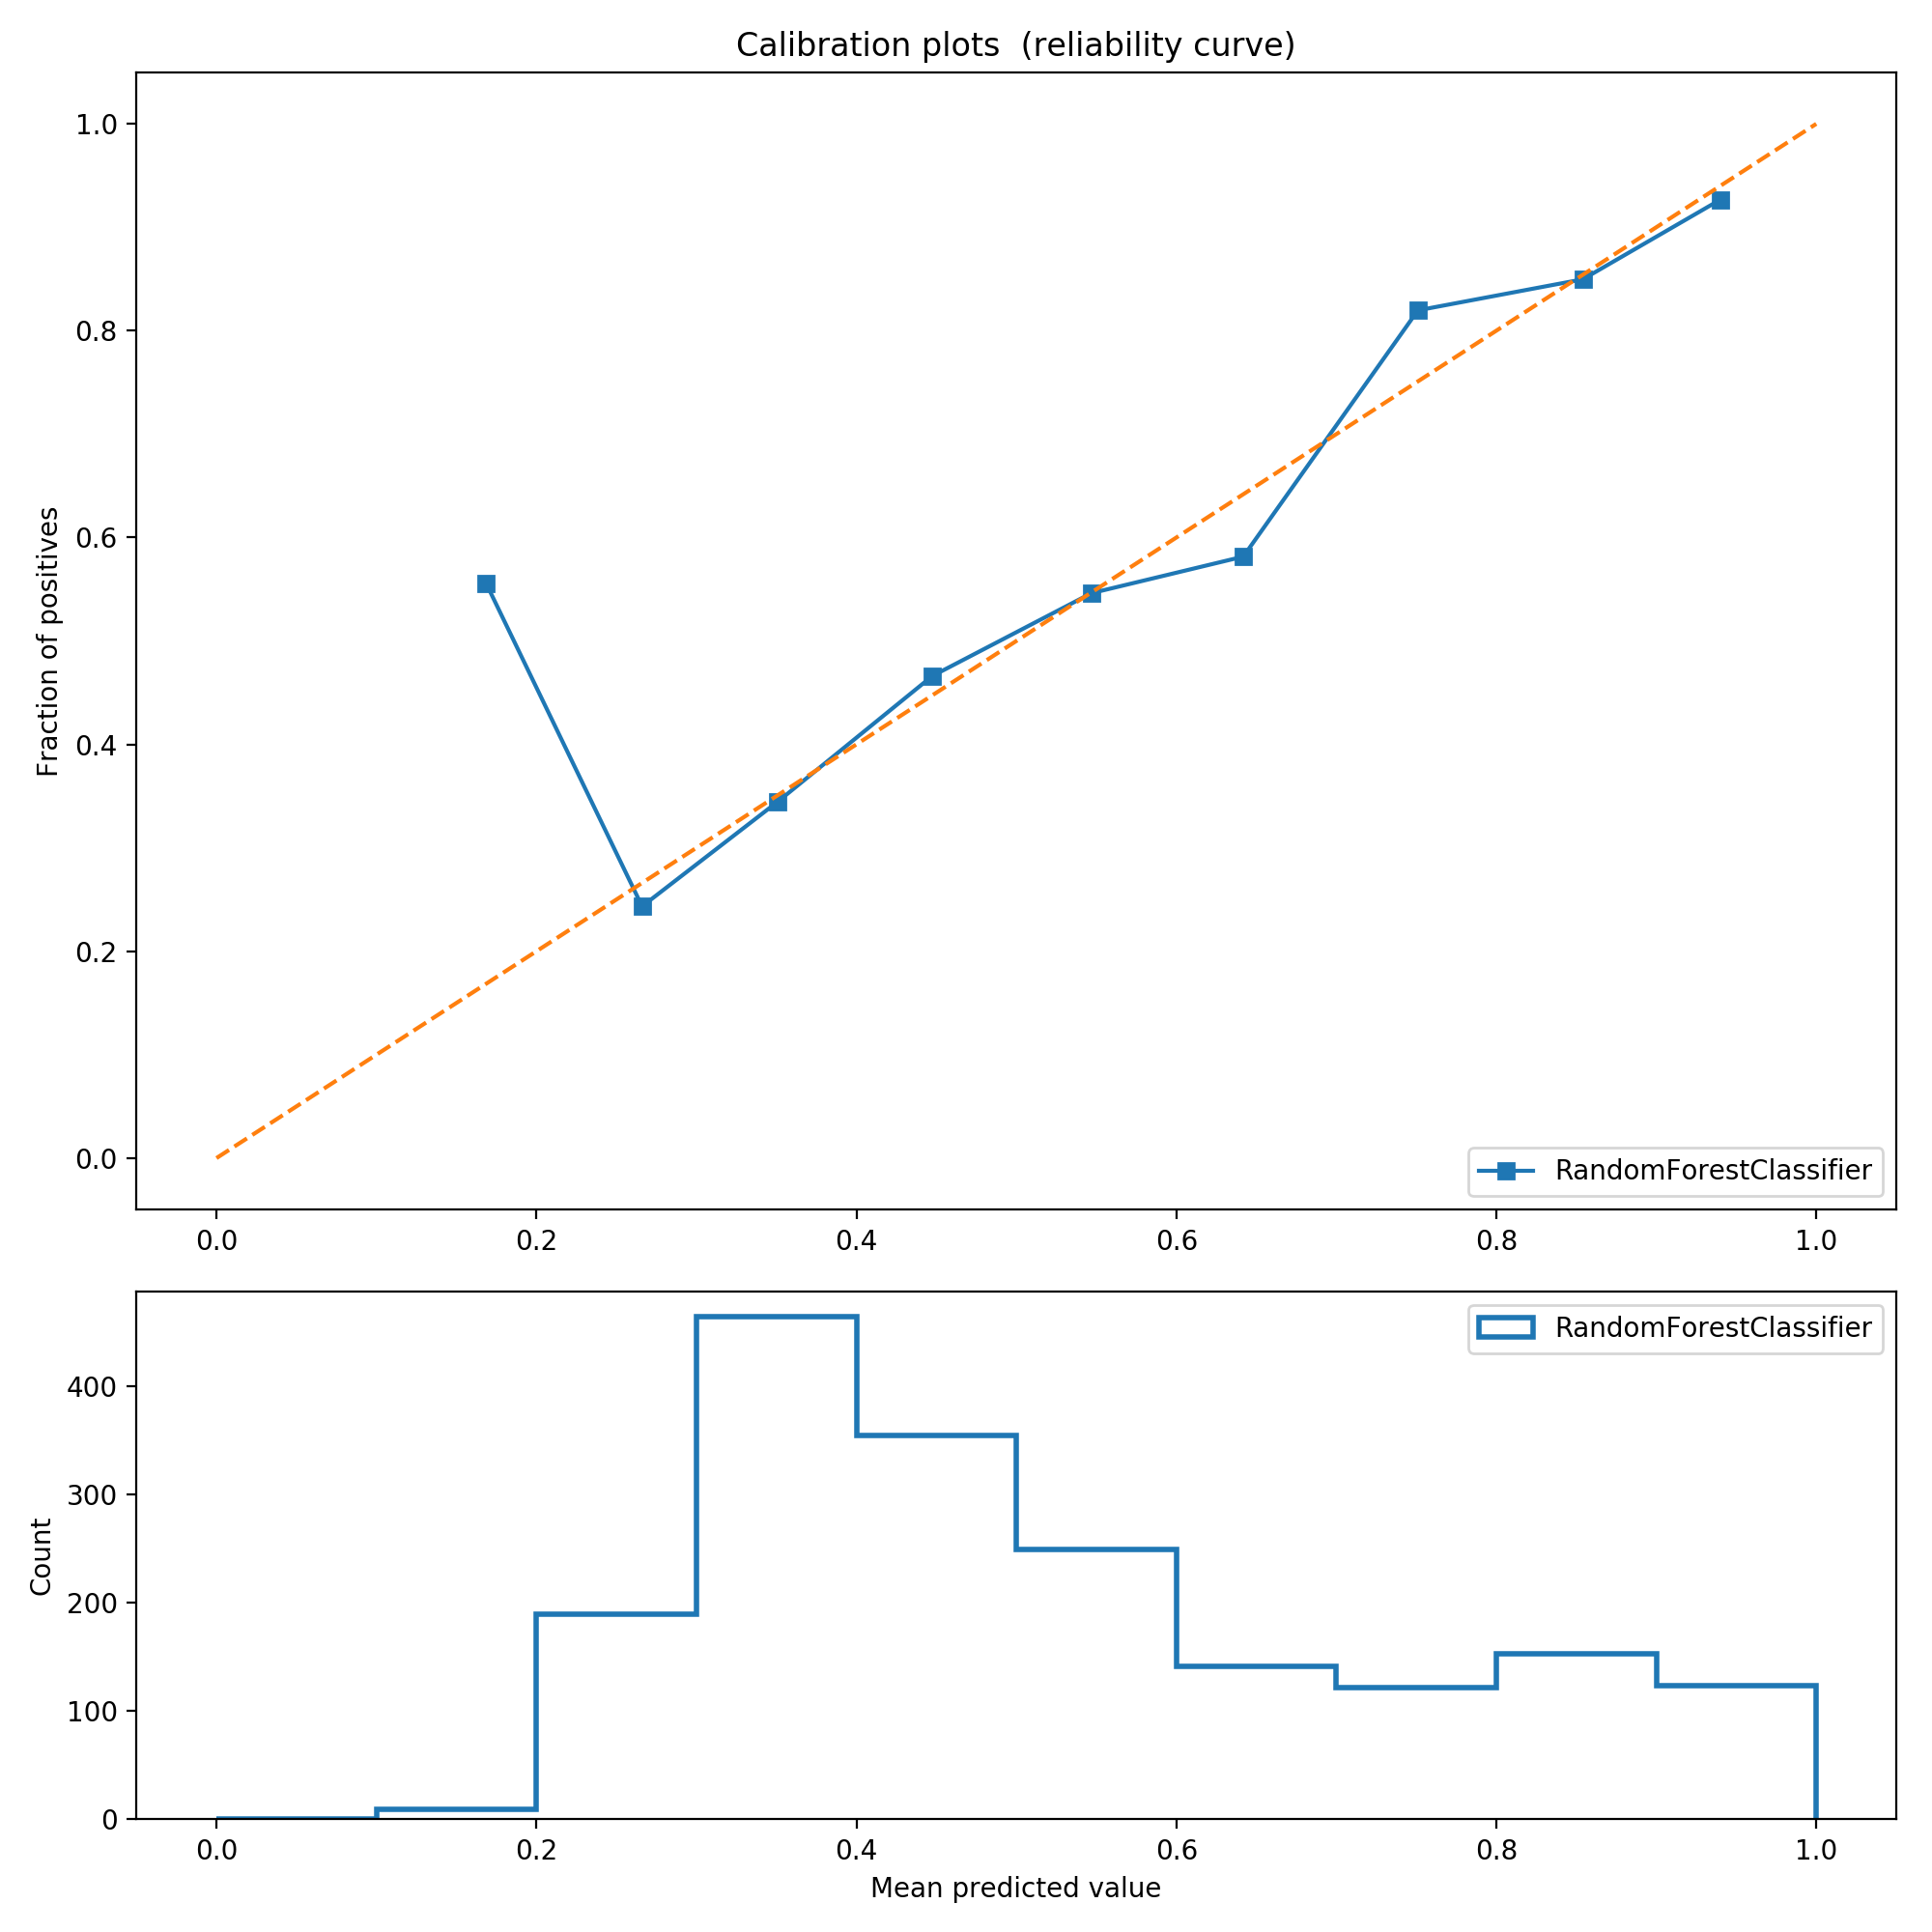

Variable:  ly_costhetastar  has relative importance:  0.1531332964231744
Variable:  MET  has relative importance:  0.15542365379073586
Variable:  mjj  has relative importance:  0.287974554269305
Variable:  jjdeta  has relative importance:  0.23629644648964498
Variable:  mly  has relative importance:  0.16717204902713978


In [36]:
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create logistic regression object
feature_cols = ['ly_costhetastar', 'MET', 'mjj', 'jjdeta', 'mly']

#also add in the weights, pTlep, and pTgamma so that we can plot these later! Otherwise, the info is removed from 
#our test sample as well! There's probably a cleaner way of doing this, but it works.

X_train_w,X_test_w,y_train,y_test = train_test_split(my_dataset.loc[:, feature_cols+['weight','pTlep','pTgamma']], 
                                                 my_dataset.loc[:,'isSignal'], test_size=0.5, random_state=21234)

#skim down to what we're training on to appease the RandomForestClassifier
X_train = X_train_w.loc[:,feature_cols]
X_test = X_test_w.loc[:, feature_cols]

#read more about the random forest classifier here: 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
model = RandomForestClassifier(n_estimators=200,max_depth=10)

# Train the model using the training sets and check score
model.fit(X_train, y_train)
model.score(X_train, y_train)

plt.close('all')

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

#code from: https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html

prob_pos = model.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ('RandomForestClassifier', ))
ax1.plot([0, 1], [0, 1], linestyle='--')
ax2.hist(prob_pos, range=(0, 1), bins=10, label='RandomForestClassifier',
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper right", ncol=2)
plt.tight_layout()

#Predict Output
#this is an array of 0's and 1's saying whether each event was more likely to be signal or background.
#the cut is on a pre-determined probability (50%). If the classifier outputs a value >= 0.5, it's signal
#otherwise, it is classified as background. This value can be tuned!
predicted = model.predict(X_test)

#here, we're printing out how important each of the variables was in the classification. 
#try adding a variable that didn't seem to have any discriminating power and see what happens!
importances = model.feature_importances_
for var, importance in zip(feature_cols, importances):
    print ('Variable: ',var,' has relative importance: ',importance)

Here's another way of visualising how accurately we predicted our test dataset, using the truth information. We can plot the truth label (whether or not the event is signal or background) vs. the classifier prediction (whether or not the random forest classifier says the event is signal or background), as a histogram, to get a collective sense of whether or not the classification is working:

<IPython.core.display.Javascript object>


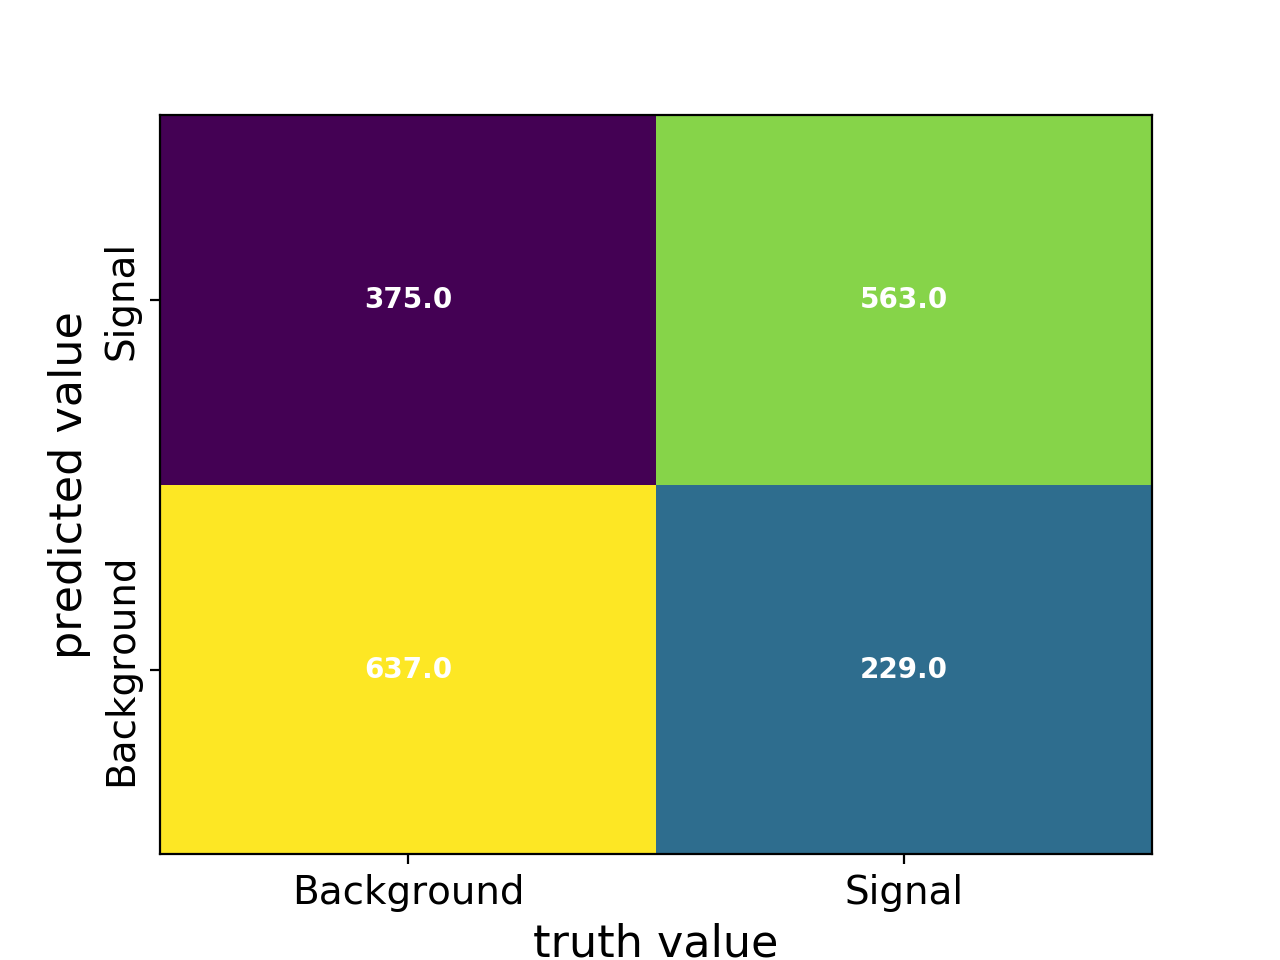

In [33]:
plt.close('all')
ax=plt.gca()

#plot the number of events showing up in each category!
hist, xbins, ybins, im = ax.hist2d(y_test.values,predicted,bins=[[0,1,2],[0,1,2]])

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, hist[i,j], 
                color="w", ha="center", va="center", fontweight="bold")
        
labels = ['Background','Signal']

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks([0.5,1.5], labels,size=14)
plt.yticks([0.5,1.5], labels,rotation='vertical',size=14,va='center')

ax.set_xlabel('truth value',size=16)
ax.set_ylabel('predicted value',size=16)
plt.show()

Now let's repeat our cut experiment, but instead of guessing mjj > 500 GeV we can use the output of our random forest classifier!

In [34]:
#first, we want to split up the X_test back to our signal and background events
#using the default predicted output from the classifier:

#go back to our bigger test sample!
X_test_w['isSignal'] = y_test #add the isSignal column back in, so we can split it in the plot
X_test_w['probSignal'] = prob_pos
bkg_test = X_test_w[X_test_w['isSignal'] == 0]
sig_test = X_test_w[X_test_w['isSignal'] == 1]

let's look at the distribution of the probabilities for signal and background!

<IPython.core.display.Javascript object>


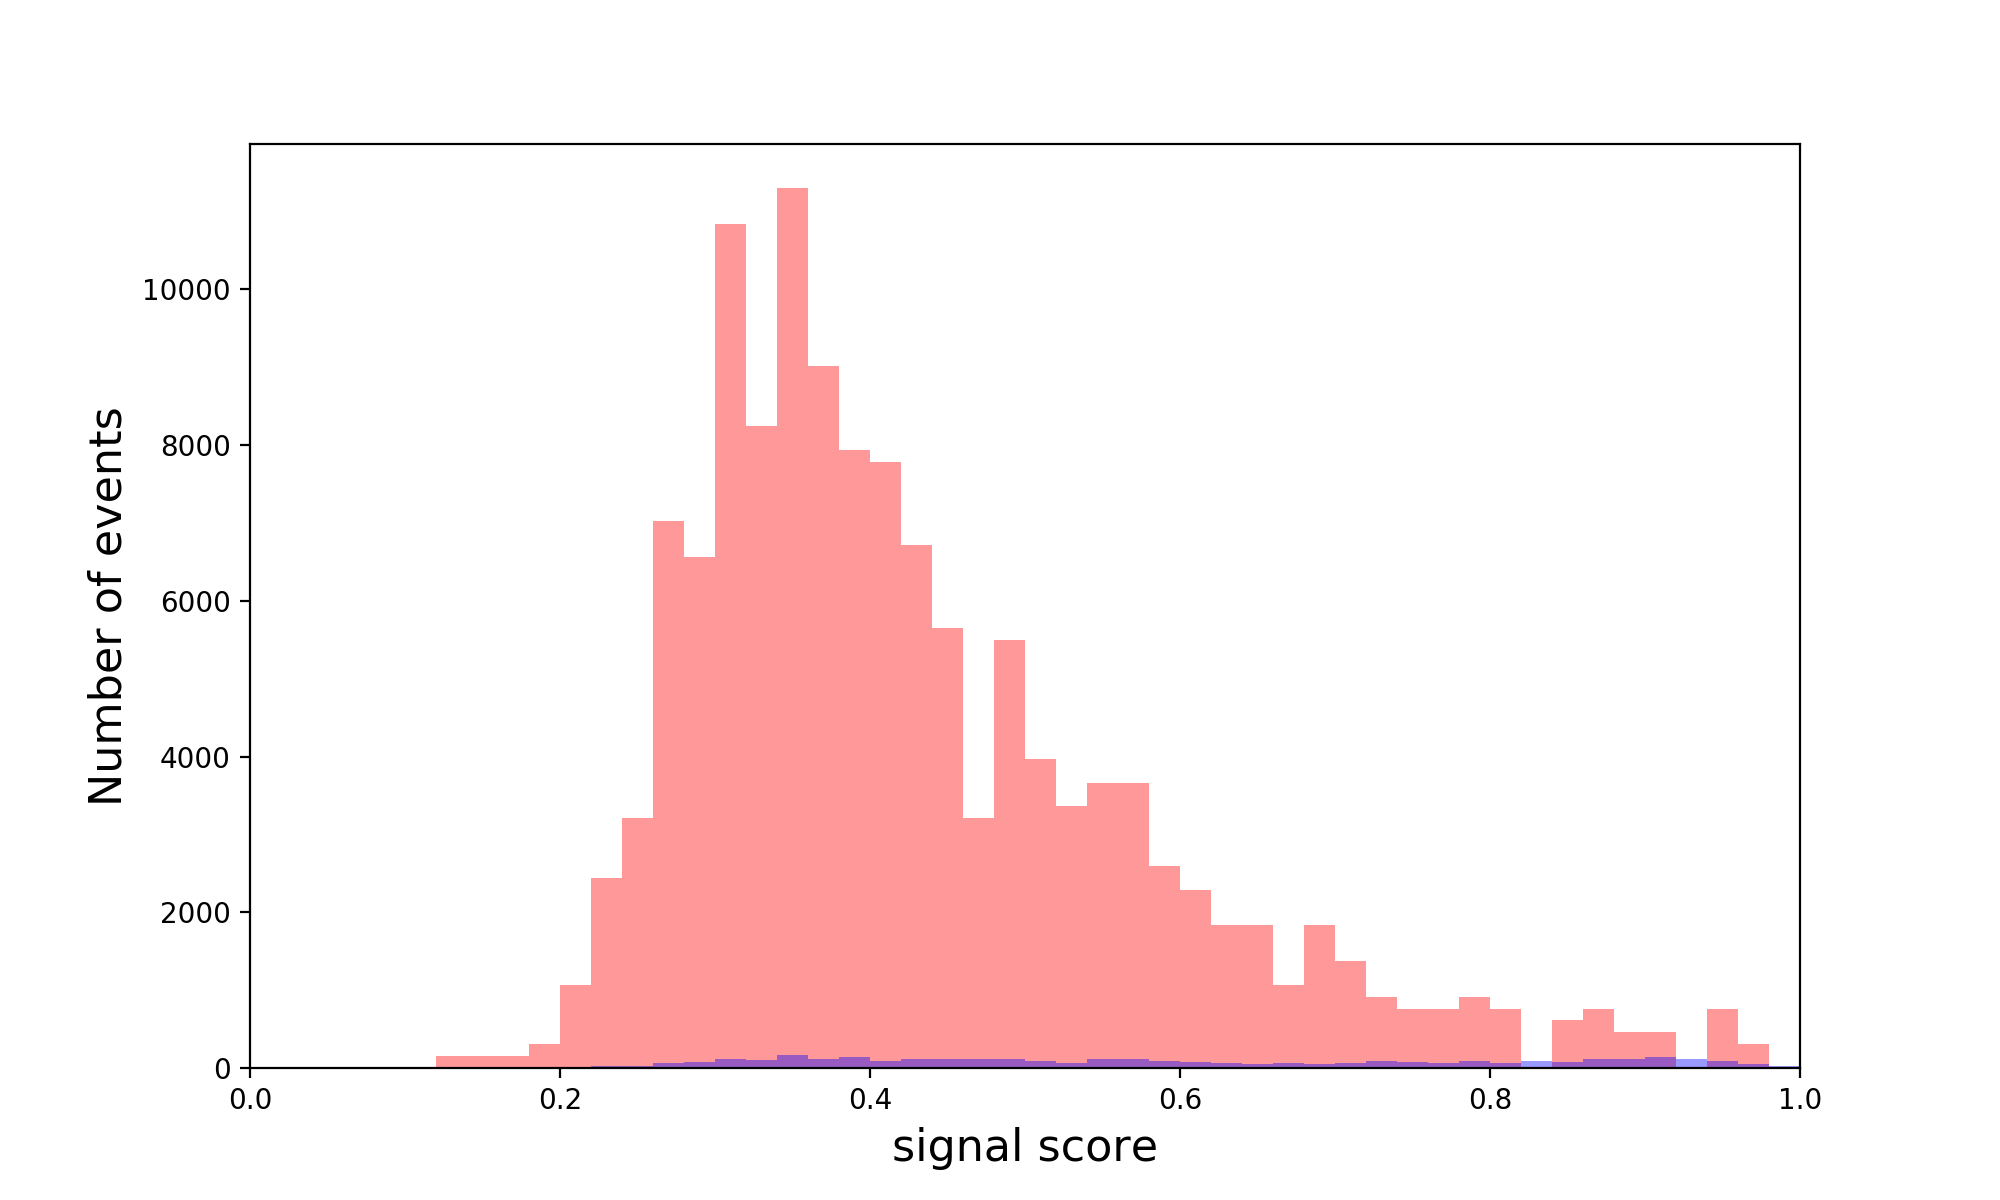

At  38.69936034115138 % of our signal MC, we keep:  8.083140877598153 % of the background
Probability of signal for this %:  0.7000000000000001


In [35]:
#you always need to close existing plots before plotting, or they'll show up on the old canvas!
plt.close('all')

fig = plt.figure(figsize=(10,6))
n_bkg, bins, _ = plt.hist(bkg_test.probSignal, weights = 2*bkg_test['weight']*scale_factors[1],bins=50,range=[0,1],label = 'background', color='red',alpha=0.4)
n_sig, bins, _ = plt.hist(sig_test.probSignal, weights = 2*sig_test['weight']*scale_factors[0],bins=50,range=[0,1],label = 'signal', color='blue',alpha=0.4)

ax=plt.gca()
ax.set_yscale('linear')
ax.set_xlabel("signal score", size=16)
ax.set_ylabel("Number of events",size=16)
ax.set_xlim(left=0.,right=1)

#and since, before, our mjj > 500 GeV cut gave us ~38% of signal, let's find the probability that 
#gives us 38% of signal remaining, and see how much background is left at that point!

total_signal = np.sum(n_sig)
total_bkg = np.sum(n_bkg)

int_sig = []; int_bkg=[]
sums =0;sumb=0
for i,j,b in zip(reversed(n_sig),reversed(n_bkg),reversed(bins)):
    sums+=i;sumb+=j
    int_sig += [sums]
    int_bkg += [sumb]
    if sums/total_signal > 0.38:
        break

print ('At ', sums/total_signal*100.,'% of our signal MC, we keep: ',sumb/total_bkg*100,'% of the background')
print ('Probability of signal for this %: ',b)

plt.show()


Ok, I admit, this is only 1% better than we did with our naive cut. You could probably reoptimize the signal probability cut to give you the maximum signal / sqrt(signal+background) and at this value do much better than a naive mjj cut, but I'll leave that as an exercise to the reader!

But let's plot the events with this probability cut anyways, and we can compare the shapes to the previous mjj plots:

<IPython.core.display.Javascript object>


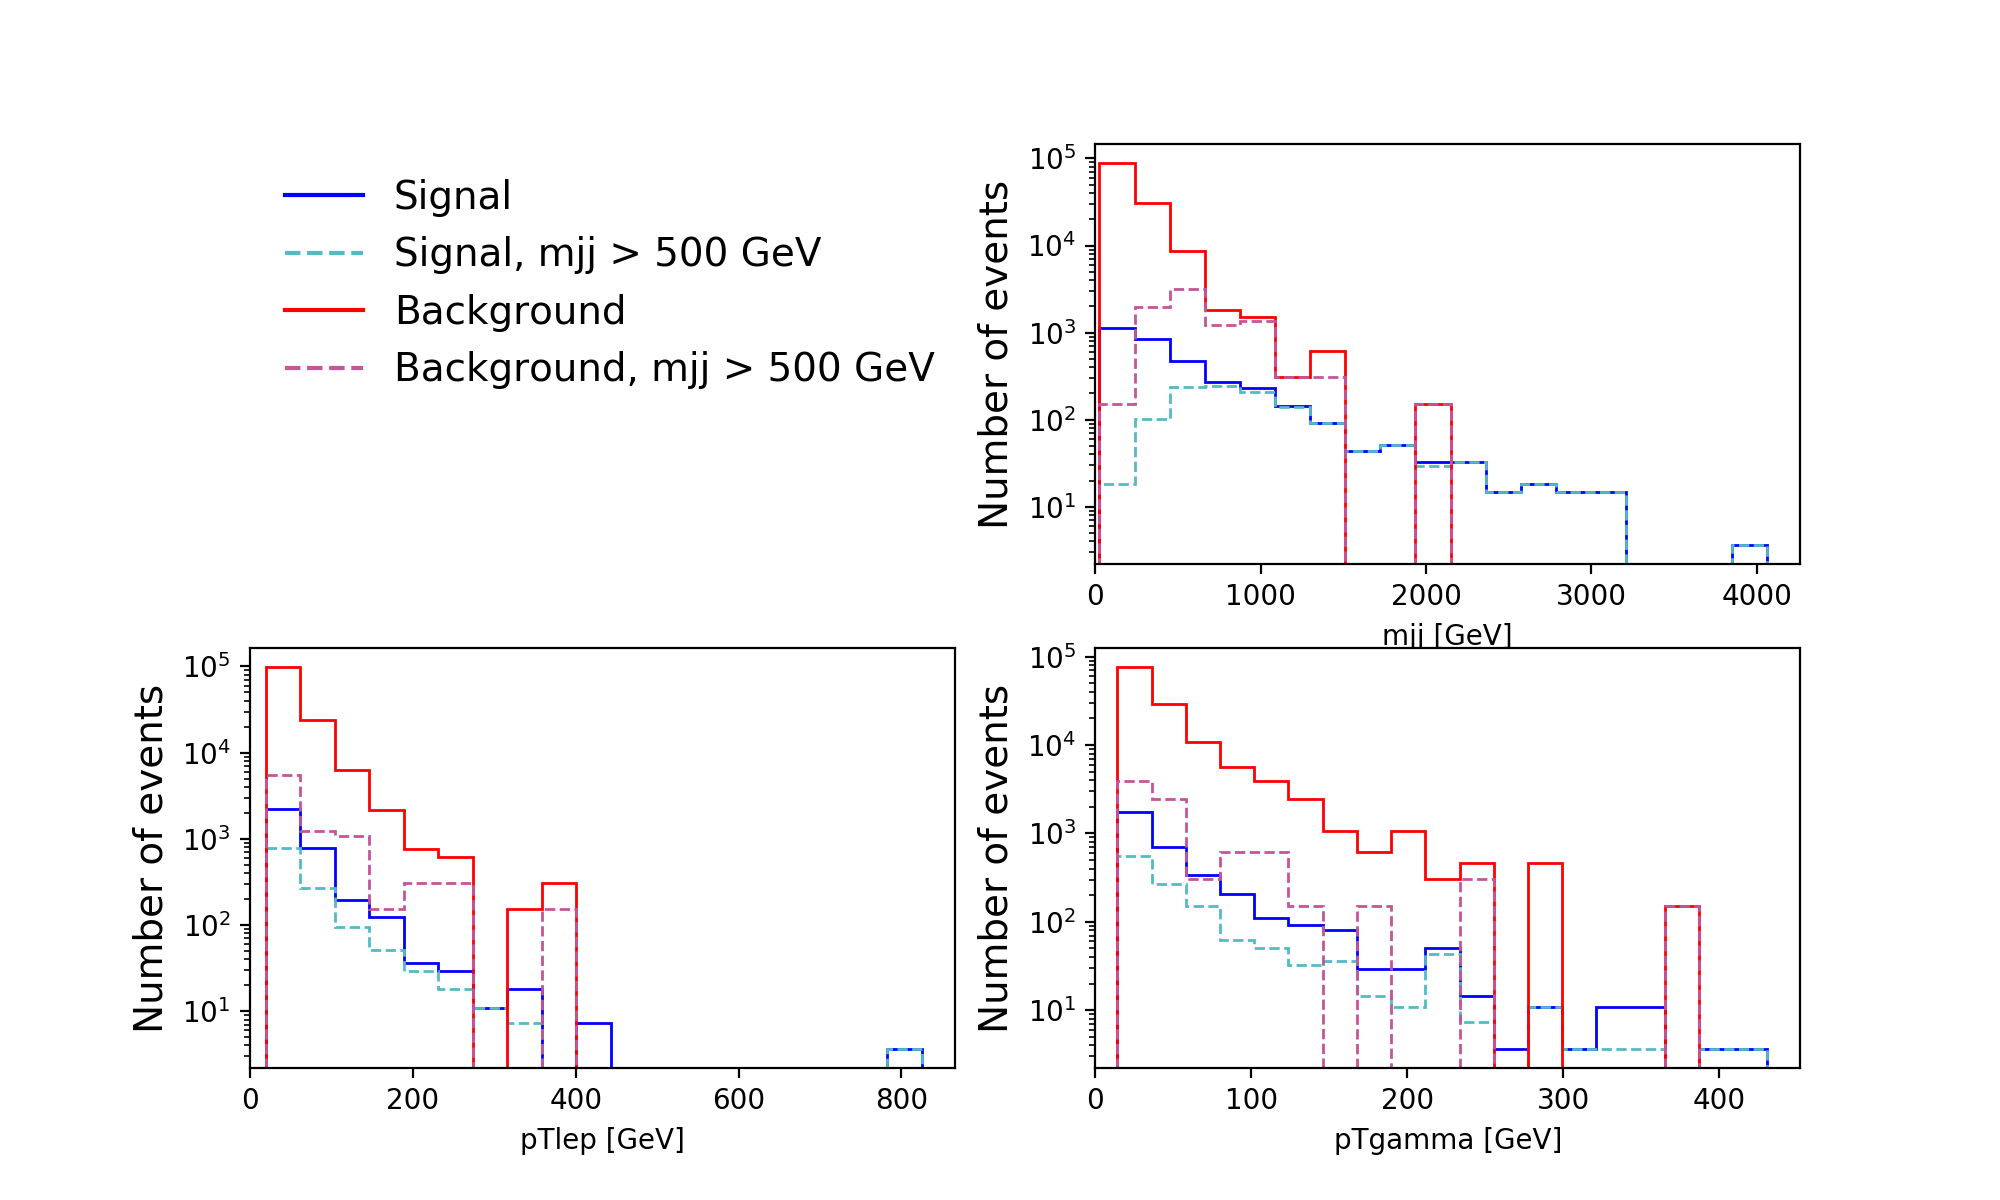

In [20]:
#you always need to close existing plots before plotting, or they'll show up on the old canvas!
plt.close('all')

fig,axes = plt.subplots(2,2,figsize=(10,6),sharex=False,squeeze=True)

#filter the signal and background to only contain events passing 40% of events (> 0.6 means ) cut
filtered_sig_test = sig_test[sig_test['probSignal'] > 0.7]
filtered_bkg_test = bkg_test[bkg_test['probSignal'] > 0.7]

#we'll the same variables as before so you can scroll up and compare!
my_variables = ['mjj','pTlep','pTgamma']

#put the legend in the first subplot
legPlot = axes[0][0]
    
legPlot.set_frame_on(False)
legPlot.get_xaxis().set_visible(False)
legPlot.get_yaxis().set_visible(False)

#this is another sort of hacky way of plotting lines - create an empty plot object with the correct style
#and make the legend from that instead!
legPlot.plot(0, 0, linestyle='-', color='blue', label = 'Signal')
legPlot.plot(0, 0, linestyle='--', color='#54bac5', label = 'Signal, mjj > 500 GeV')
legPlot.plot(0, 0, linestyle='-', color='red', label = 'Background')
legPlot.plot(0, 0, linestyle='--', color='#c55498', label = 'Background, mjj > 500 GeV')
legPlot.legend(loc = 'upper left',prop={'size':14},framealpha=0)

for ax,var in zip(axes.flatten()[1:],my_variables):
    
    #calculate some default binning dependent on the max and min values of the variable in the signal dataset
    #here I subtract a bit from the min and add to the max just to make sure I'm covering everything
    bins=np.linspace(min(sig_test[var])-1,max(sig_test[var])+1,20)
    
    # need to add a factor of 2 to the weights, because this is now only half the events so the sum of weights in scale_factors is incorrect!
    ax.hist(np.clip(sig_test[var], bins[0], bins[-1]), weights = 2*sig_test['weight']*scale_factors[0],bins=bins,color='blue',
             fill=False,histtype='step',label='Signal',linestyle='-')

    ax.hist(np.clip(filtered_sig_test[var], bins[0], bins[-1]), weights = 2*filtered_sig_test['weight']*scale_factors[0],bins=bins,color='#54bac5',
             fill=False,histtype='step',label='Signal, predicted sig',linestyle='--')    

    ax.hist(np.clip(bkg_test[var], bins[0], bins[-1]), weights = 2*bkg_test['weight']*scale_factors[0],bins=bins,color='red',
             fill=False,histtype='step',label='Background',linestyle='-')

    ax.hist(np.clip(filtered_bkg_test[var], bins[0], bins[-1]), weights = 2*filtered_bkg_test['weight']*scale_factors[0],bins=bins,color='#c55498',
             fill=False,histtype='step',label='Background, predicted sig',linestyle='--')  
    
    ax.set_yscale('log')
    ax.set_xlim(left=0)
    ax.set_ylabel('Number of events', fontsize=14)
    ax.set_xlabel(var+' [GeV]')
    
plt.show()